In [1]:
from Uncertainty import *
from uncertaintyMetric import *
from utils import *
from tensorflow.keras.optimizers import Adam

K.clear_session()
check_tensorflow_gpu()

Checking Tensorflow Version:
Tensorflow built with CUDA? True
Tensorflow version: 2.6.2
# GPU available: 1
CUDA: 64_112 | cuDNN: 64_8
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


***

In [2]:
well_names = ['well {}'.format(p+1) for p in range(16)]
templist, well = np.arange(2,50,step=16), {}
for i in range(16):
    well[i] = templist+i
wells = np.array(list(well.values()))
print(wells[5])

[ 7 23 39]


In [4]:
p = Proxy(ncol_data=[7, 23, 39], measure_type=1, nMCSamples=5000)

c:\Users\381792\AppData\Local\anaconda3\envs\earth36\lib\site-packages\pyearth\earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
c:\Users\381792\AppData\Local\anaconda3\envs\earth36\lib\site-packages\pyearth\earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
c:\Users\381792\AppData\Local\anaconda3\envs\earth36\lib\site-packages\pyearth\earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine prec

In [5]:
print('p.x_train: {} | p.y_train: {}'.format(p.x_train.shape, p.y_train.shape))

X_train = MinMaxScaler().fit_transform(p.x_train)
y_train = MinMaxScaler().fit_transform(p.y_train.reshape(-1,1))

p.x_train: (500, 7) | p.y_train: (500,)


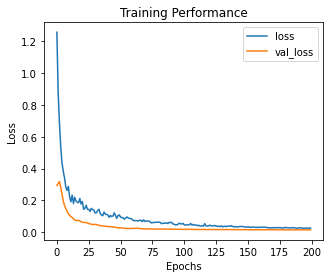

In [8]:
def make_proxy(reg=L1(1e-5), drop=0.1, opt=Adam(1e-3), loss='mse'):
    keras.backend.clear_session()
    def dense_block(inp, units):
        _ = Dense(units, kernel_regularizer=reg)(inp)
        _ = BatchNormalization()(_)
        _ = PReLU()(_)
        _ = Dropout(drop)(_)
        return _
    inp = Input(shape=(7))
    x = dense_block(inp, 64)
    x = dense_block(x, 128)
    x = dense_block(x, 32)
    x = dense_block(x, 16)
    out = Dense(1, activation='linear')(x)
    proxy = Model(inp, out)
    proxy.compile(optimizer=opt, loss=loss, metrics=['mse','mae'])
    return proxy

model = make_proxy()
#model.summary()
fit = model.fit(X_train, y_train,
                    epochs = 200,
                    validation_split = 0.2,
                    batch_size = 50,
                    verbose = False)
plot_loss(fit)

R2: 0.965 | MSE: 0.00147


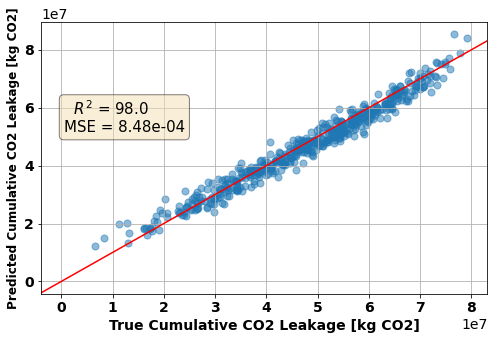

In [41]:
y_pred = model.predict(X_train)

yscaler = MinMaxScaler().fit(p.y_train.reshape(-1,1))
temp = yscaler.inverse_transform(y_pred)
temp[temp<0] = 0

mse = mean_squared_error(y_train, y_pred)
r2  = r2_score(y_train, y_pred)
print('R2: {:.3f} | MSE: {:.5f}'.format(r2,mse))

mybox = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.figure(figsize=(8,5))
plt.scatter(p.y_train, temp, s=50, alpha=0.5)
plt.axline([0,0],[1,1], c='r', linestyle='-'); plt.grid('on')
plt.xlabel('True Cumulative CO2 Leakage [kg CO2]', weight='bold', size=14); plt.ylabel('Predicted Cumulative CO2 Leakage [kg CO2]', weight='bold', size=12)
plt.xticks(weight='bold', size=14); plt.yticks(weight='bold', size=14)
plt.text(0.05e7, 5.15e7, '  $R^2$ = {:.1f}\nMSE = {:.2e}'.format(98.0,8.48e-4), size=15, bbox=mybox)
plt.gca().yaxis.get_offset_text().set_fontsize(14)
plt.gca().xaxis.get_offset_text().set_fontsize(14)

#plt.title('True vs. Predicted Cumulative CO2 Leakage - ANN ROM') 
#fontname='Times New Roman'
plt.show()

R2: 0.762 | MSE: 0.00932


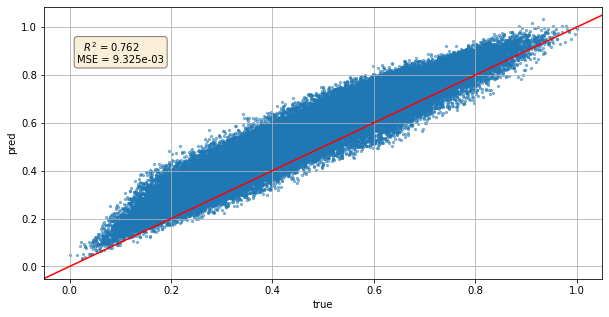

In [ ]:
x2 = MinMaxScaler().fit_transform(p.mc_design)
y2 = {}
for i in range(60):
    y2[i] = MinMaxScaler().fit_transform(p.mc_data[i].reshape(-1,1))
y2_pred = model.predict(x2)

mse = mean_squared_error(y2[59], y2_pred)
r2  = r2_score(y2[59], y2_pred)
print('R2: {:.3f} | MSE: {:.5f}'.format(r2, mse))

plt.figure(figsize=(10,5))
plt.scatter(y2[59], y2_pred, s=5, alpha=0.5)
plt.axline([0,0],[1,1], c='r', linestyle='-'); plt.grid('on')
plt.xlabel('true'); plt.ylabel('pred')
plt.text(0.015, 0.85, '  $R^2$ = {:.3f}\nMSE = {:.3e}'.format(r2,mse), bbox=mybox)
plt.show()

In [ ]:
post_p90mp10_mean, post_p90mp10_time, post_p90mp10_iData, post_mean, post_mean_iData, nSamples, mc_obj_post = p.results

U = np.insert(post_p90mp10_time/1e6,0,p.prior_p90mp10/1e6)
#T = np.insert(time_point,0,0)
print('The prior uncertainty: {:.3f}'.format(U[0]))
print('The end point posterior uncertainty: {}'.format(U[len(U)-1]))

The prior uncertainty: 38.717
The end point posterior uncertainty: 11.922412143949318


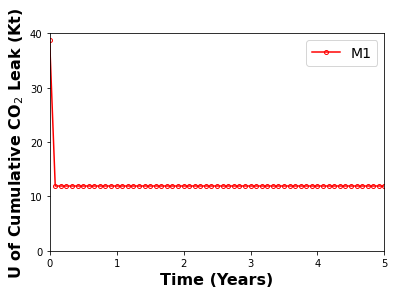

In [ ]:
plt.figure()
plt.plot(np.array(p.time_point)/360,U,marker='o',markersize=4,markerfacecolor='none',color='red',label='M1')
#plt.plot(np.array(time_point)/360,U_2,marker='^',markersize=4,markerfacecolor='none',color='blue',label='M2')
#plt.plot(np.array(time_point)/360,U_4,marker='x',markersize=4,color='black',label='M1+M2')
#plt.plot(np.array(time_point)/360,U_3,marker='+',markersize=5,color='green',label='M1+M2+M3')    
plt.xlabel('Time (Years)',fontsize=16,fontweight="bold")
plt.ylabel('U of Cumulative CO$_2$ Leak (Kt)',fontsize=16,fontweight="bold")
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
plt.xlim([0,p.Total_time/360])
plt.ylim([0,40])
plt.legend(loc='upper right',fontsize=14)
plt.show()

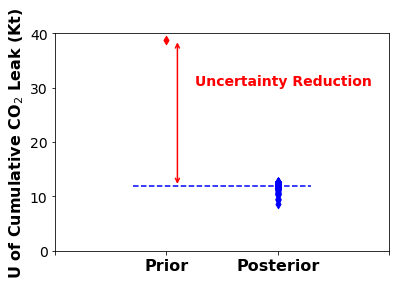

In [ ]:
plt.figure()
plt.scatter(1,p.prior_p90mp10/1e6,marker='d',color='red')
xl=np.zeros(p.nDataRealization)
for i in range(0,p.nDataRealization):
    xl[i]= 2
plt.scatter(xl,post_p90mp10_iData/1e6,marker='d',color='blue')
plt.plot((0.7,2.3),(post_p90mp10_mean/1e6,post_p90mp10_mean/1e6),ls='--',color='blue')
#plt.plot((1.1,1.1),(post_p90mp10_mean,prior_p90mp10),ls='-',color='red')
plt.annotate('',xy=(1.1,post_p90mp10_mean/1e6),xycoords='data',xytext=(1.1,p.prior_p90mp10/1e6),textcoords='data',arrowprops={'arrowstyle':'<->','color':'red','lw':'1.5'})
plt.figtext(0.45,0.7,"Uncertainty Reduction",fontsize=14, fontweight='bold', color='red')
#plt.xlabel('',fontsize=14)
plt.ylabel('U of Cumulative CO$_2$ Leak (Kt)',fontsize=16,fontweight="bold")
plt.xticks(np.arange(4),('','Prior','Posterior',''),fontsize=16,fontweight="bold")
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
plt.ylim([0,40])
#plt.legend(loc='center right')
plt.show()

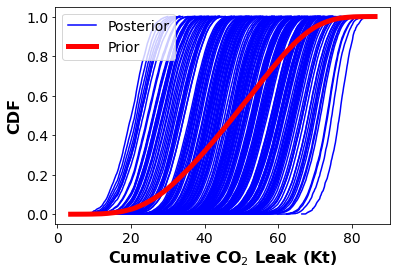

In [ ]:
# plot CDF for prior and posterior distribution of obj
plt.figure()
num_bins =100
hist, bin_edges = np.histogram(p.mc_obj/1e6, bins=num_bins)
cdf = np.cumsum(hist)
cdf1=np.zeros(num_bins)

for i in range(0,len(mc_obj_post)):
    hist_post, bin_edges_post = np.histogram(mc_obj_post[i]/1e6, bins=num_bins)
    cdf_post = np.cumsum(hist_post)
    cdf1_post=np.zeros(num_bins)
    for j in range(0,num_bins):
        cdf1_post[j]=float(cdf_post[j])/len(mc_obj_post[i])
    if i==0:
        plt.plot(bin_edges_post[1:],cdf1_post,'b',label="Posterior")
    else:
        plt.plot(bin_edges_post[1:],cdf1_post,'b')
        
for i in range(0,num_bins):
    cdf1[i]=float(cdf[i])/p.nMCSamples
plt.plot(bin_edges[1:],cdf1,c='r',linewidth=5,label="Prior")

plt.xlabel('Cumulative CO$_2$ Leak (Kt)',fontsize=16,fontweight="bold")
plt.ylabel('CDF',fontsize=16,fontweight="bold")
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
plt.legend(loc='upper left',fontsize=14)
plt.show()

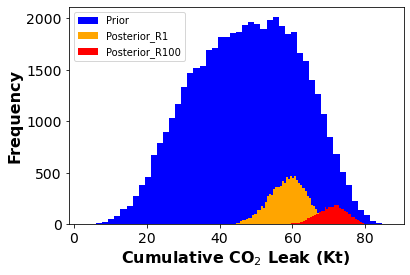

In [ ]:
#plot histogram
plt.figure()
num_bins1=50
plt.hist(p.mc_obj/1e6,bins=num_bins1,color='blue',label='Prior')
plt.hist(mc_obj_post[0]/1e6,bins=num_bins1,color='orange',label='Posterior_R1')
plt.hist(mc_obj_post[99]/1e6,bins=num_bins1,color='red',label='Posterior_R100')
plt.xlabel('Cumulative CO$_2$ Leak (Kt)',fontsize=16,fontweight="bold")   
plt.ylabel('Frequency',fontsize=16,fontweight="bold")
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
plt.legend(loc='upper left')
plt.show()

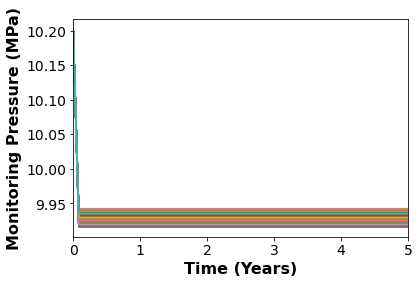

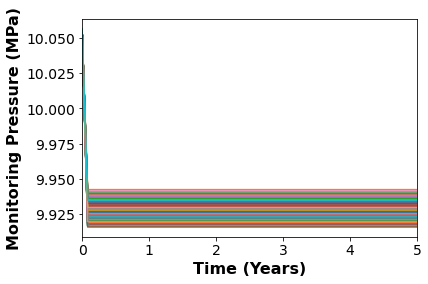

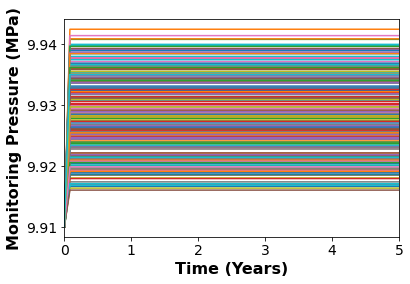

In [ ]:
for iLoc in range(0, len(p.nColumn_data)):
    plt.figure()
    for i in range(0,p.nDataRealization):
        data_plot=np.insert(p.synthetic_data[i][p.nTimeSeries*iLoc:p.nTimeSeries*(iLoc+1)],0,p.data_train_read_raw0[0][iLoc])
        plt.plot(np.array(p.time_point)/360,data_plot)
    plt.xlabel('Time (Years)',fontsize=16,fontweight="bold")
    plt.ylabel('Monitoring Pressure (MPa)',fontsize=16,fontweight="bold")
    #plt.ylabel('CO$_2$ Saturation',fontsize=16,fontweight="bold")
    plt.rc('xtick',labelsize=14)
    plt.rc('ytick',labelsize=14)
    plt.xlim([0,p.Total_time/360])
    #plt.ylim([10.200,10.235])
    plt.show()

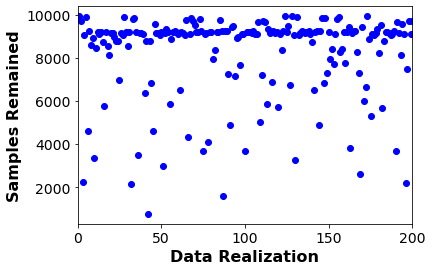

In [ ]:
plt.figure()
plt.scatter(np.arange(1,p.nDataRealization+1,1),nSamples,marker='o',color='blue')
plt.xlabel('Data Realization',fontsize=16,fontweight="bold")
plt.ylabel('Samples Remained',fontsize=16,fontweight="bold")
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
plt.xlim([0,p.nDataRealization])
plt.show()

***

In [ ]:
# permeability map
perm = np.moveaxis(np.loadtxt('perm_base.txt').reshape(10,51,51,3)[...,0], 0, -1)[...,0]
logpermx = np.log10(perm * 1.01325e15)
print('perm: {} | logpermx: {}'.format(perm.shape, logpermx.shape))

# monitoring locations
x = np.arange(1,51,step=16)
locs = np.array(list(np.array(np.meshgrid(x,x)).T)).reshape(16,2)

# leaky locations
temp = np.zeros((31,51,51)).flatten()
temp[[26531, 26551, 27561, 27581, 28091, 26031]] = 1E10
temp2 = np.flip(np.rot90(temp.reshape(31,51,51).T,3),1)
ws = np.rot90(np.array(np.where(temp2[...,10]>100)),3)

# uncertainty reduction results
ur = pd.read_csv('_misael_results/optimization_by_column.csv')
choose = 'presWAT'

### FIGURE
plt.figure(figsize=(20,8))

# permeability map
im = plt.imshow(logpermx, cmap='coolwarm', interpolation='hamming')

# injection well
plt.scatter(25.5, 25.5, c='yellow', s=500, marker='$\swarrow$')
plt.scatter(25.75, 25.5, s=500, marker='o', edgecolors='yellow', facecolors='none')
plt.text(27.5, 25, 'injector', c='yellow', size=15, weight='bold')

# leaky wells
for i in range(ws.shape[0]):
    plt.scatter(ws[i,0], ws[i,1], c='gold', s=300, edgecolors='gray')
    plt.scatter(ws[i,0], ws[i,1], c='k', marker='$L{}$'.format(i), s=180)
    
# monitoring wells
u = plt.scatter(locs[:,0], locs[:,1], c=ur[choose], marker='s', s=100, cmap='jet_r')
plt.colorbar(u, label='Uncertainty Reduction [$x10^6$] - {}'.format(choose), fraction=0.046, pad=0.04)
for i in range(locs.shape[0]):
    plt.text(locs[i,0]+0.5, locs[i,1]+0.5, 'm{}'.format(i), color='k', size=10)

# plot attributes
plt.colorbar(im, label='Log-Permeability [log-mD]', fraction=0.046, pad=0.04)
plt.xticks(np.linspace(0,50,11,dtype='int'), labels=np.linspace(0,4000,11,dtype='int'))
plt.yticks(np.linspace(0,50,11,dtype='int'), labels=np.linspace(0,4000,11,dtype='int'))
plt.gca().invert_yaxis()
mpl.rcParams['figure.dpi'] = 300
plt.show()

In [ ]:
result = pd.read_csv('_misael_results/optimization_by_column.csv')
print(result.shape)

plt.figure(figsize=(15,15))
im=plt.imshow(result.T, cmap='jet')
plt.colorbar(im, label='Uncertainty Reduction [$x10^6$]', fraction=0.009, pad=0.03)
plt.xticks(range(16), labels=np.arange(1,17)); plt.xlabel('Well Locations')
plt.yticks(range(3), labels=['presWAT','co2sl','temp']); plt.ylabel('Measure Type')
plt.title('Uncertainty Reduction by Well Location for each Measure Type')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(result, '.-')
plt.xticks(range(16), labels=np.arange(1,17)); plt.xlabel('Well Locations')
plt.ylabel('Uncertainty Reduction [$x10^6$]'); plt.grid('on')
plt.title('Uncertainty Reduction by Well Location for each Measure Type')
plt.legend(['presWAT','co2sl','temp'])
plt.show()

In [ ]:
# select       = 7
# plot_bounds  = [-3, 3]

# local_method = 'trust-krylov'
# x0           = [1.5, 1.5]
# glob_bounds  = [-2, 2]

# opt = FullOpt(select)
# local_res,  local_res_df  = opt.local_opt(x0=x0, method=local_method)
# global_res, global_res_df = opt.global_opt(varbounds=glob_bounds)
# opt.make_plot(global_res_df, local_res_df, mbounds=plot_bounds, 
#               showcontours=True, showtrajectory=True, angle=[45,225])

Brute Force

In [ ]:
view_results('LR', suptitle='Linear Regression ROM', folder='_misael_results')
view_results('MARS', suptitle='MARS ROM', folder='_misael_results')

***

In [ ]:
# General settings
Main_Directory   = os.getcwd()
Data_Directory   = os.path.join(Main_Directory, 'data')
titles           = ['.', 'Pressure', 'CO2 Saturation (l)', 'Temperature', 'Pressure + CO2 Saturation']
unc_params       = ['perm4', 'perm5', 'perm6', 'kmult']

MeasureType      = 1                           # Measurement type: 1 for pressure; 2 for CO2 saturation; 3 for tempeture, 4 for pressure+CO2 saturation                     
Total_time       = 1800                        # Total injection and post-injection time (days)
nTimeSeries      = 60                          # The number of measurement time series
nInterval        = 1                           # Measurement interval, default value = 1/Month

nTrain           = 500                         # The number of training simulations
Obj_filename     = 'run_co2mt.his'             # Objective file name
nColumn_obj      = 50                          # The column(s) in which the object of interest is located
nColumn_data     = [7]    #[7]                 # The column in which the data measurement is located 

x_max            = [1e-14, 1e-14, 1e-14, 2.0]  # Upper bounds for all the uncertain parameters
x_min            = [1e-19, 1e-19, 1e-19, 0.5]  # Lower bounds for all the uncertain parameters
ROMs_validation  = 0                           # ROMs cross-validation flag
nMCSamples       = 10000  #100000              # Number of monte carlo samples
nParam           = 4                           # Number of uncertain parameters
nDataRealization = 100    #200                 # Number of data realizations
err_option       = 3                           # Type of err option (2=MeanAE, 3=MaxAE)
time_sensitivity = 1                           # Whether consider time sensitivity for UR flag
post_processing  = 1                           # Plotting flag
print('Current Working Directory: {}'.format(Main_Directory))
print('Data Directory: {}'.format(Data_Directory))

## Step 1: Perfrom training simulation
# This step is done in a seperate code.

roms = [Ridge(), Ridge()]

***
# END